<a href="https://colab.research.google.com/github/protechanalysis/US-Power-Generation-Analysis/blob/main/EDA_US_Power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load required libraries
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# Load data files
gen_load <- read_csv("/content/drive/MyDrive/us power/organised_Gen.csv")
state <- read_csv("/content/drive/MyDrive/us power/states.csv") %>% select(State, Code)

Rows: 496774 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): STATE, TYPE OF PRODUCER, ENERGY SOURCE
dbl (4): YEAR, MONTH, DAY, GENERATION (Megawatthours)

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 51 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): State, Abbrev, Code

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:

# Join state data with energy generation data and exclude STATE column
gen <- gen_load %>% inner_join(state, by = c("STATE" = "Code")) %>%
  select(-STATE)

In [4]:
# Check for missing values in the generated dataset
colSums(is.na(gen))

YEAR                      MONTH 
                         0                          0 
                       DAY           TYPE OF PRODUCER 
                         0                          0 
             ENERGY SOURCE GENERATION (Megawatthours) 
                         0                          0 
                     State 
                         0

In [5]:
# Rename columns for clarity
gen_rename <- gen %>%
  rename(
    "TYPE_OF_PRODUCER" = trimws("TYPE OF PRODUCER"),
    "ENERGY_SOURCE" = trimws("ENERGY SOURCE"),
    "GENERATION_Megawatthours" = trimws("GENERATION (Megawatthours)"))

In [6]:
# Filter out total values for each type of producer
gen_filter <- gen_rename %>%
  filter(!grepl("^Total.*", TYPE_OF_PRODUCER))

# Filter out 'Total' from the Energy source column
gen_filter_source <- gen_filter %>% filter(ENERGY_SOURCE != "Total")


In [7]:
# Generate a summary of generation by energy source
gen_filter_source %>% group_by(ENERGY_SOURCE) %>%
  summarize(
    Min = min(GENERATION_Megawatthours),
    Mean_gen = mean(GENERATION_Megawatthours),
    `1st_quantile` = quantile(GENERATION_Megawatthours, probs = 0.25),
    Median = quantile(GENERATION_Megawatthours, probs = 0.50),
    `3rd_quantile` = quantile(GENERATION_Megawatthours, probs = 0.75),
    Max = max(GENERATION_Megawatthours))

ENERGY_SOURCE,Min,Mean_gen,1st_quantile,Median,3rd_quantile,Max
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Coal,-8037.0,1001470.19,5358.0000,57676.000,1121067.00,12992757
Geothermal,-140.0,165917.63,10080.5000,20622.000,97341.50,1085778
Hydroelectric Conventional,-2271.0,230900.63,2448.0000,24506.830,124418.40,11182501
Natural Gas,-6092.9,444700.23,4289.6975,36007.000,329290.50,18305637
Nuclear,-29677.0,2075090.80,863474.0000,1511230.500,2851507.25,8883354
Other,-16861.0,11844.51,48.2500,3413.190,11234.75,319159
Other Biomass,-999.0,12001.46,699.0750,3057.000,10188.02,212451
Other Gases,-655.0,26558.49,1.0000,2180.000,24444.50,413354
Petroleum,-26541.0,22842.15,14.0000,429.000,5218.69,5054796


In [10]:
 #Split 'type of producer' into 'producer' and 'company'
producer_split <- gen_filter_source %>% mutate(
  energy_producer = word(TYPE_OF_PRODUCER, 1, sep = ", "),
  energy_company = word(TYPE_OF_PRODUCER, 2, sep = ", ")) %>%
  select(-TYPE_OF_PRODUCER)

# Convert generation data into terawatt hours and categorize into renewable and non-renewable
generation <- producer_split %>% mutate(
  type_of_energy_source = ifelse(
    ENERGY_SOURCE %in% c("Coal", "Natural Gas", "Petroleum",
                         "Other Gases", "Nuclear", "Other"),
    "Non_Renewable", "Renewable"),
  generation_TWh = GENERATION_Megawatthours/1000000)



In [11]:
# View the final generated dataset
head(generation)

YEAR,MONTH,DAY,ENERGY_SOURCE,GENERATION_Megawatthours,State,energy_producer,energy_company,type_of_energy_source,generation_TWh
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
2001,1,1,Coal,18410,Alaska,Electric Generators,Electric Utilities,Non_Renewable,0.018410
2001,1,1,Petroleum,64883,Alaska,Electric Generators,Electric Utilities,Non_Renewable,0.064883
2001,1,1,Natural Gas,305277,Alaska,Electric Generators,Electric Utilities,Non_Renewable,0.305277
2001,1,1,Hydroelectric Conventional,104549,Alaska,Electric Generators,Electric Utilities,Renewable,0.104549
2001,1,1,Wind,87,Alaska,Electric Generators,Electric Utilities,Renewable,0.000087
2001,1,1,Coal,19742,Alaska,Combined Heat and Power,Electric Power,Non_Renewable,0.019742


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


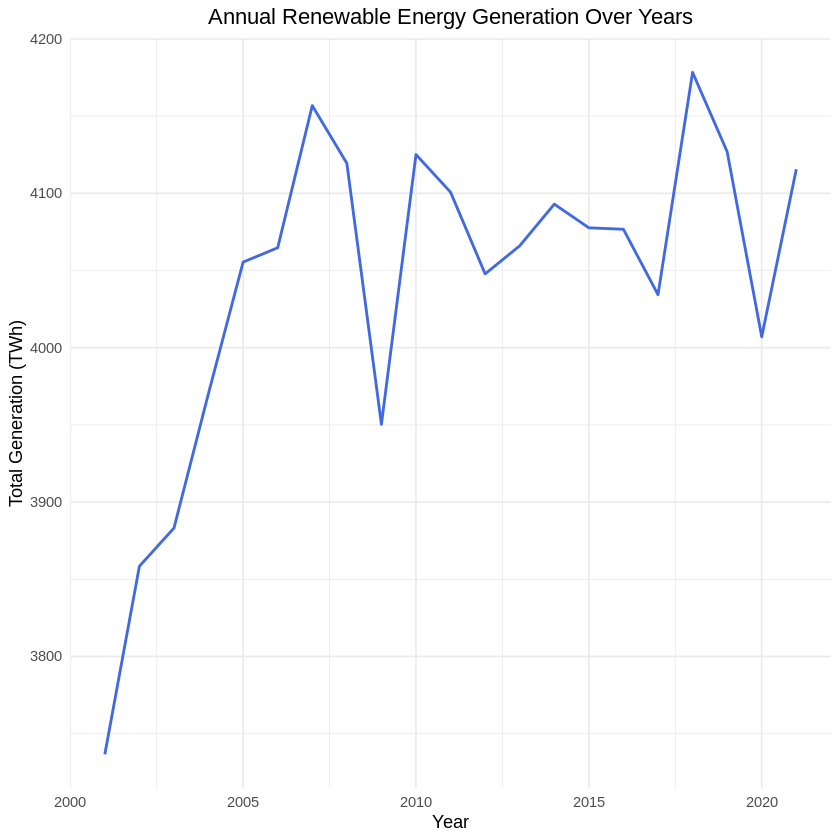

In [12]:
# Trend of total renewable energy generation over the years
generation %>%
  group_by(YEAR) %>%
  filter(YEAR != 2022) %>%
  summarise(total_generation_TWh = sum(generation_TWh)) %>%
  ggplot(aes(x = YEAR, y = total_generation_TWh)) +
  geom_line(color = "royalblue", size = 0.8) +
  labs(title = "Annual Renewable Energy Generation Over Years",
       x = "Year", y = "Total Generation (TWh)") +
  theme_minimal() + theme(plot.title = element_text(hjust = 0.5))


`summarise()` has grouped output by 'YEAR'. You can override using the
`.groups` argument.


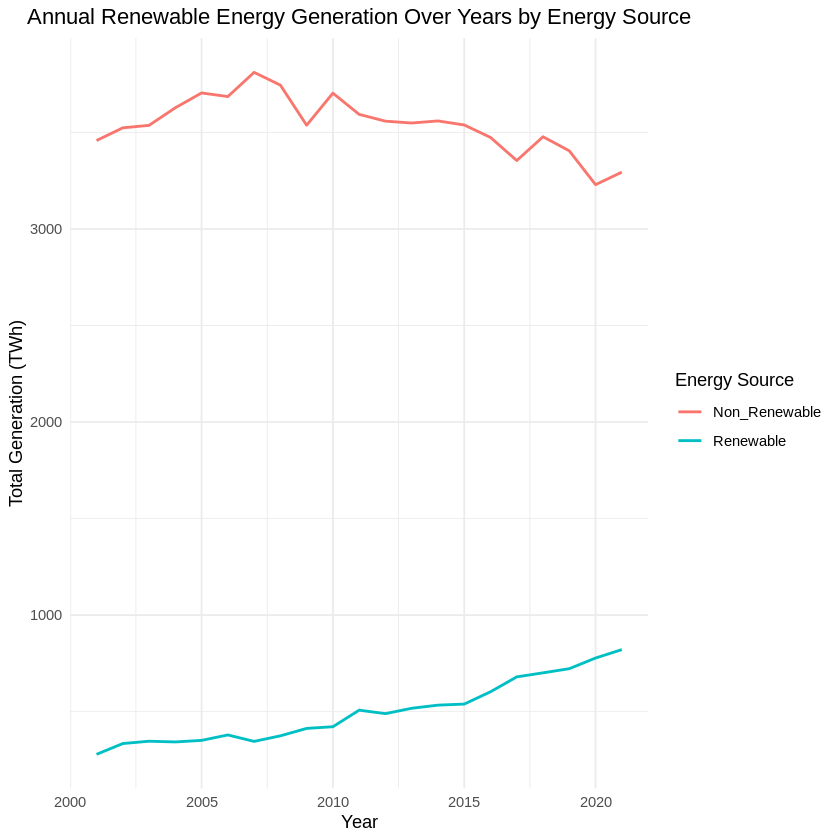

In [13]:
# Trend of renewable and non-renewable energy generation over the years
generation %>%
  group_by(YEAR, type_of_energy_source) %>%
  filter(YEAR != 2022) %>%
  summarise(total_generation_TWh = sum(generation_TWh)) %>%
  ggplot(aes(x = YEAR, y = total_generation_TWh, color = type_of_energy_source)) +
  geom_line(size = 0.8) +
  labs(title = "Annual Renewable Energy Generation Over Years by Energy Source",
       x = "Year", y = "Total Generation (TWh)", color = "Energy Source") +
  theme_minimal() + theme(plot.title = element_text(hjust = 0.5))


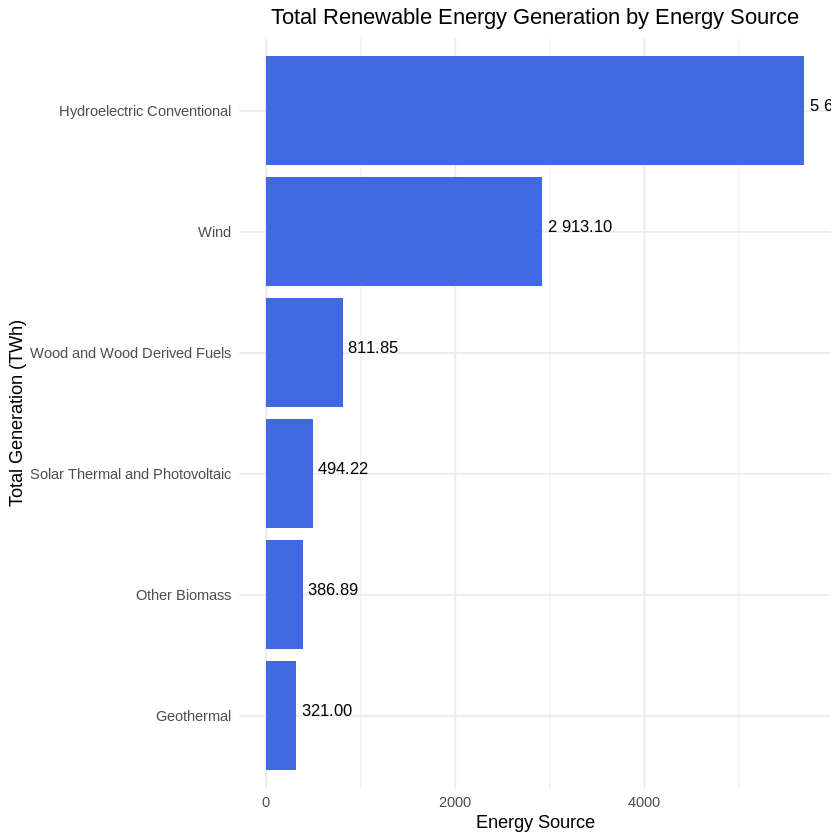

In [14]:
# Total renewable energy generation by energy source (excluding Pumped Storage)
renewable <- generation %>%
  filter(type_of_energy_source == "Renewable", YEAR != 2022, ENERGY_SOURCE != "Pumped Storage")

# Bar plot of total renewable energy generation by energy source
renewable %>%
  group_by(ENERGY_SOURCE) %>%
  summarise(total_generation = sum(generation_TWh)) %>%
  arrange(desc(total_generation)) %>%
  ggplot(aes(x = reorder(ENERGY_SOURCE, total_generation), y = total_generation)) +
  geom_col(fill = "royalblue") + coord_flip() +
  geom_text(aes(label = scales::number(total_generation, accuracy = 0.01)),
            hjust = -0.1, vjust = 0, size = 3.5, color = "black") +
  labs(title = "Total Renewable Energy Generation by Energy Source",
       x = "Total Generation (TWh)", y = "Energy Source") +
  theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

`summarise()` has grouped output by 'YEAR'. You can override using the
`.groups` argument.


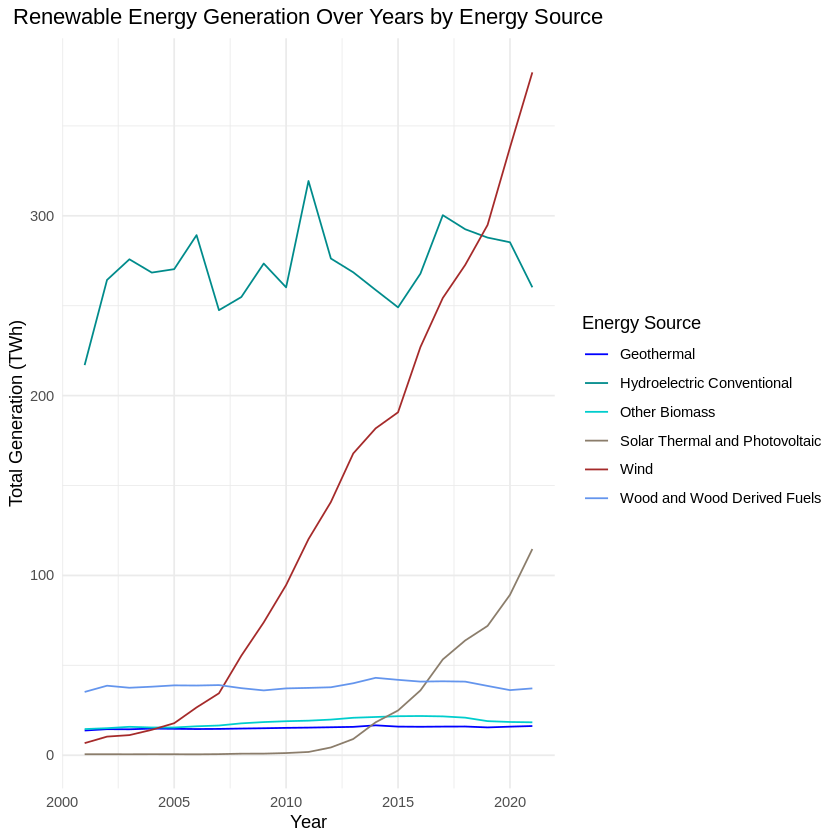

In [15]:
# Line plot of renewable energy generation over the years by energy source
color_palette <- c("blue1", "darkcyan", "cyan3", "bisque4", "brown", "cornflowerblue")
renewable %>%
  group_by(YEAR, ENERGY_SOURCE) %>%
  summarise(total_generation = sum(generation_TWh)) %>%
  ggplot(aes(x = YEAR, y = total_generation, color = ENERGY_SOURCE)) +
  geom_line(size = 0.5) +
  scale_color_manual(values = color_palette) +
  labs(title = "Renewable Energy Generation Over Years by Energy Source",
       x = "Year", y = "Total Generation (TWh)", color = "Energy Source") +
  theme_minimal() + theme(plot.title = element_text(hjust = 0.5))


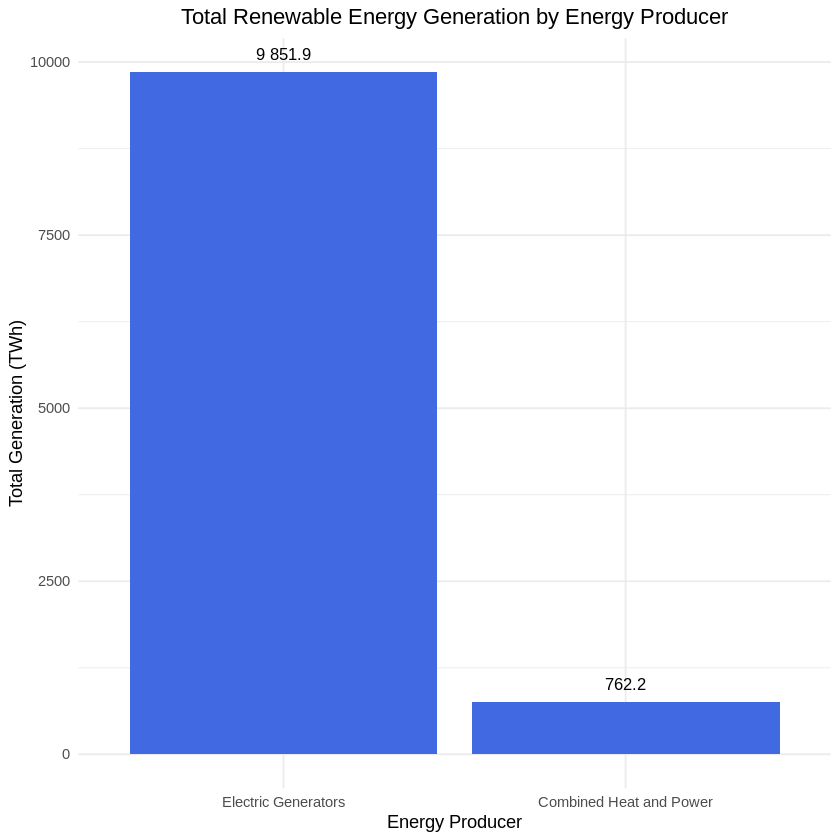

In [16]:
# Total renewable energy generation by energy producer
renewable %>% group_by(energy_producer) %>%
  summarise(total_generation = sum(generation_TWh)) %>%
  ggplot(aes(x = reorder(energy_producer, -total_generation), y = total_generation)) +
  geom_col(fill = "royalblue") +
  geom_text(aes(label = scales::number(total_generation, accuracy = 0.1)),
            hjust = 0.5, vjust = -1, size = 3.5, color = "black") +
  labs(title = "Total Renewable Energy Generation by Energy Producer",
       x = "Energy Producer", y = "Total Generation (TWh)") +
  theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

`summarise()` has grouped output by 'YEAR'. You can override using the
`.groups` argument.


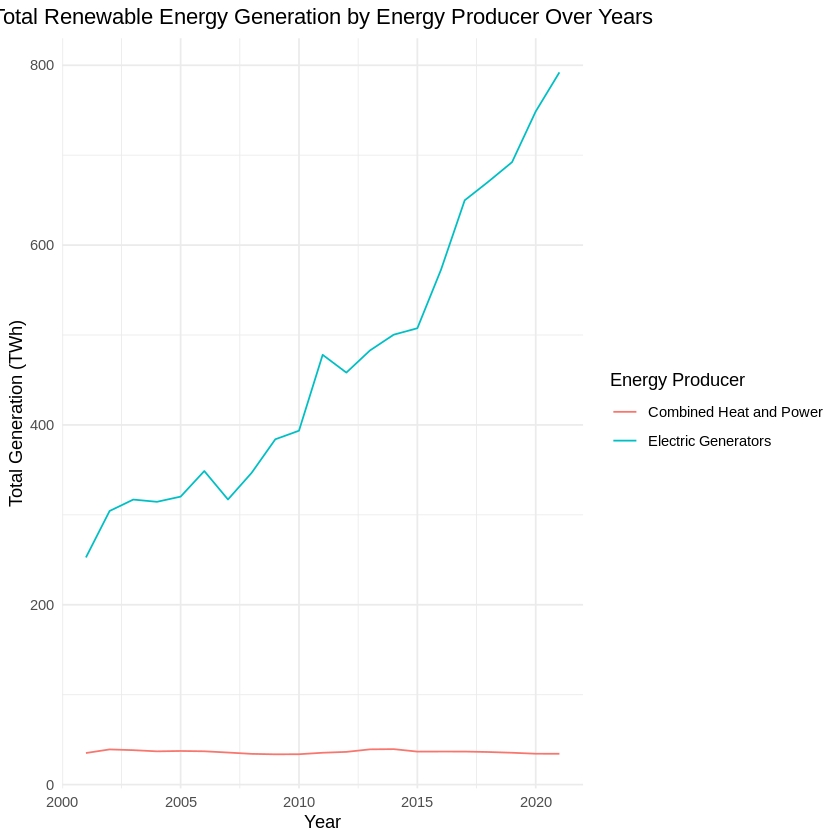

In [17]:
# Trend of total renewable energy generation by energy producer over the years
renewable %>% group_by(YEAR, energy_producer) %>%
  summarise(total_generation = sum(generation_TWh)) %>%
  ggplot(aes(x = YEAR, y = total_generation, color = energy_producer)) +
  geom_line() +
  labs(title = "Total Renewable Energy Generation by Energy Producer Over Years",
       x = "Year", y = "Total Generation (TWh)", color = "Energy Producer") +
  theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

`summarise()` has grouped output by 'YEAR'. You can override using the
`.groups` argument.


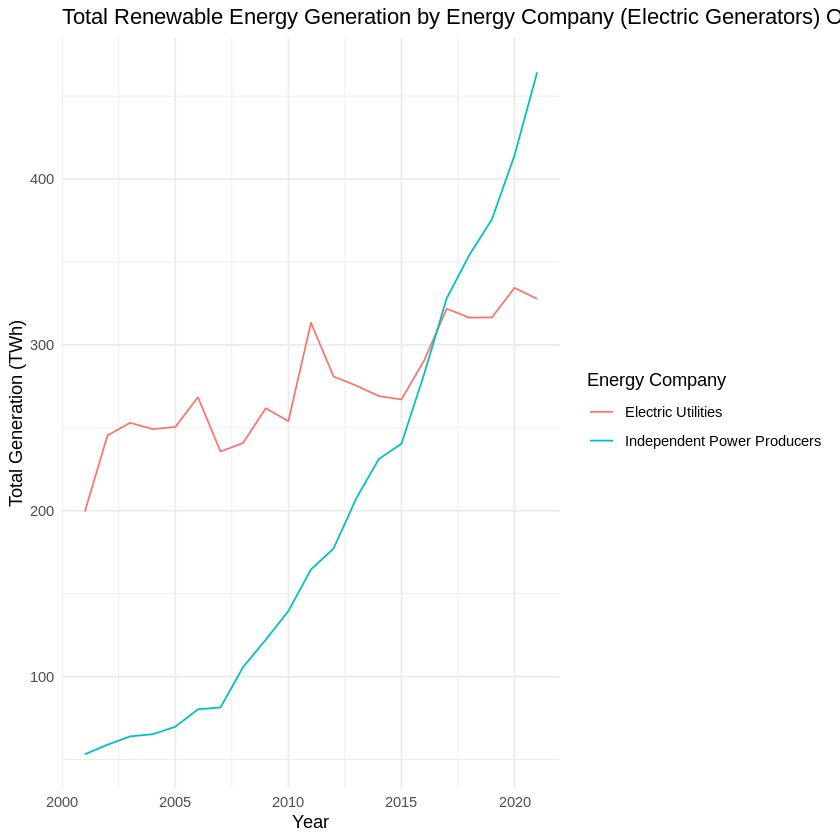

In [18]:
# Total renewable energy generation by energy company for electric generators
renewable %>% group_by(YEAR, energy_company) %>%
  filter(energy_producer == "Electric Generators") %>%
  summarise(total_generation = sum(generation_TWh)) %>%
  ggplot(aes(x = YEAR, y = total_generation, color = energy_company)) +
  geom_line() +
  labs(title = "Total Renewable Energy Generation by Energy Company (Electric Generators) Over Years",
       x = "Year", y = "Total Generation (TWh)", color = "Energy Company") +
  theme_minimal()

Selecting by total_generation


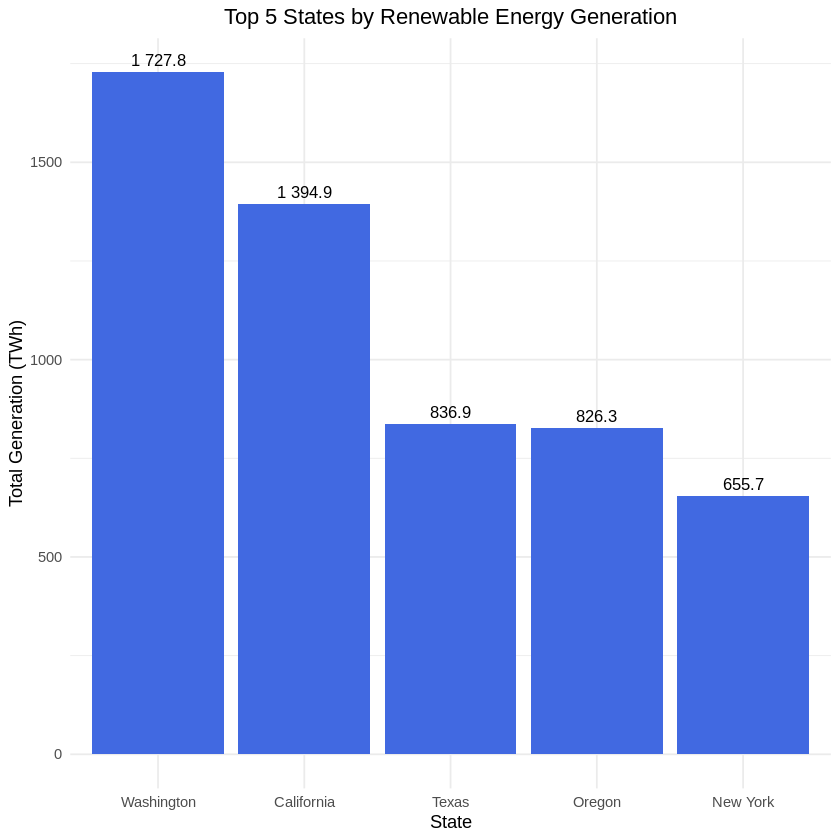

In [19]:
# Top 5 states by renewable energy generation
renewable %>% group_by(State) %>%
  summarise(total_generation = sum(generation_TWh)) %>%
  arrange(desc(total_generation)) %>% top_n(5) %>%
  ggplot(aes(x = reorder(State, -total_generation), y = total_generation)) +
  geom_col(fill = "royalblue") +
  labs(title = "Top 5 States by Renewable Energy Generation",
       x = "State", y = "Total Generation (TWh)") +
  geom_text(aes(label = scales::number(total_generation, accuracy = 0.1)),
            hjust = 0.5, vjust = -0.5, size = 3.5, color = "black") +
  theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

`summarise()` has grouped output by 'State'. You can override using the
`.groups` argument.


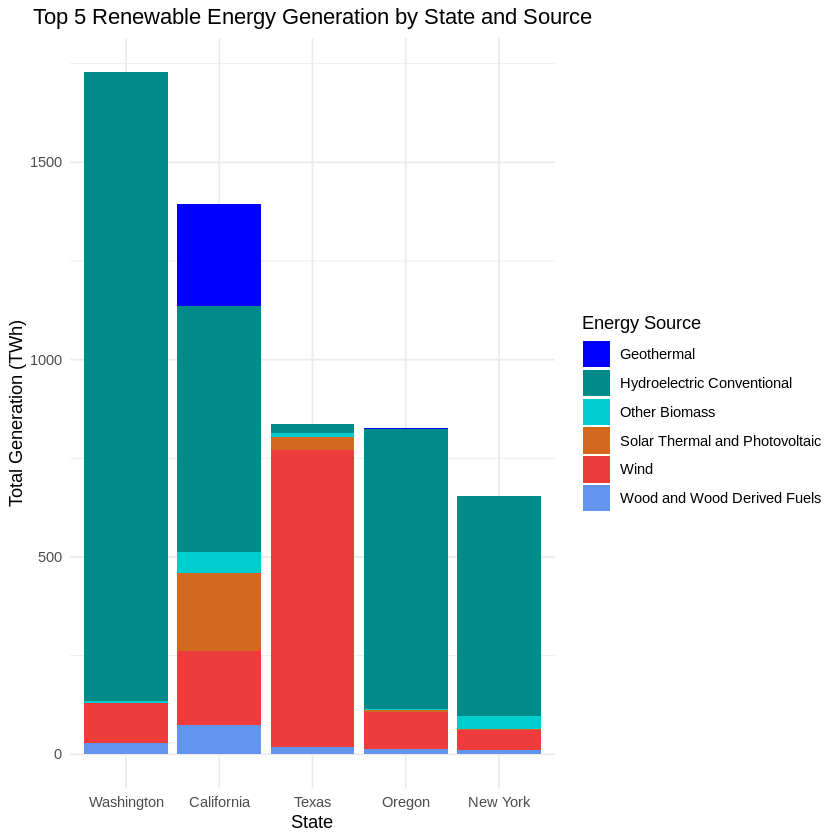

In [20]:
# Top 5 renewable energy generation by state and source
color_palette2 <- c("blue1", "darkcyan", "cyan3", "chocolate", "brown2", "cornflowerblue")
renewable %>% group_by(State, ENERGY_SOURCE) %>%
  summarise(total_generation = sum(generation_TWh)) %>%
  arrange(desc(total_generation)) %>%
  filter(State %in% c("Washington", "Texas", "Oregon", "New York",
                      "California")) %>%
  ggplot(aes(x = reorder(State, -total_generation), y = total_generation, fill = ENERGY_SOURCE)) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = color_palette2) +
  labs(title = "Top 5 Renewable Energy Generation by State and Source",
       x = "State", y = "Total Generation (TWh)",
       fill = "Energy Source") +
  theme_minimal() + theme(plot.title = element_text(hjust = 0.5))

`summarise()` has grouped output by 'YEAR'. You can override using the
`.groups` argument.


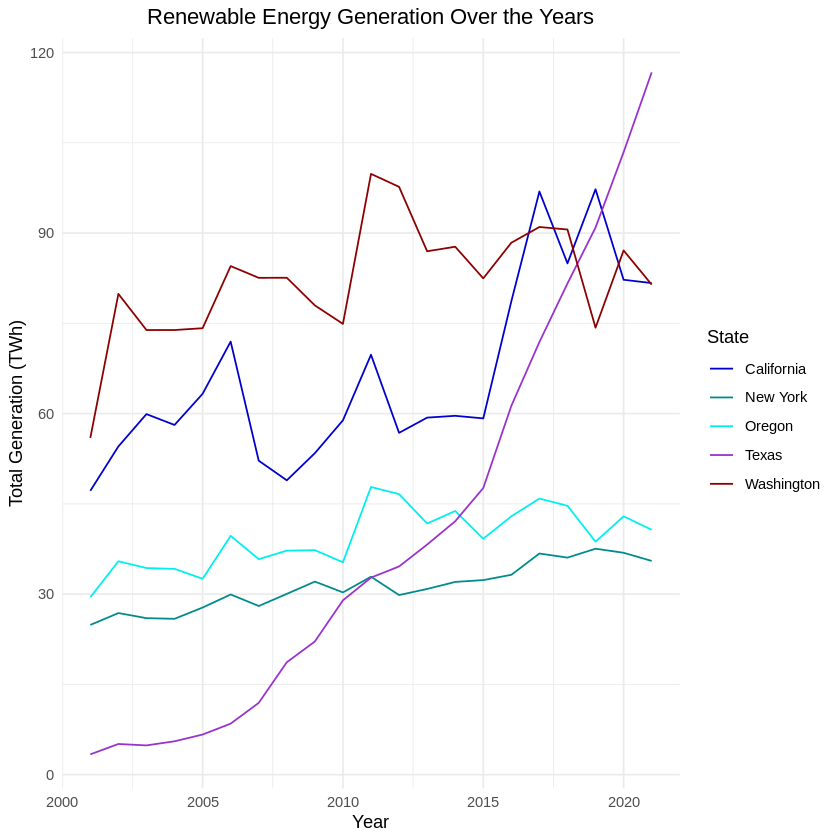

In [21]:
# Trend of renewable energy generation over the years by state
renewable_summary <- renewable %>% group_by(YEAR, State) %>%
  summarise(total_generation = sum(generation_TWh)) %>%
  arrange(desc(total_generation)) %>%
  filter(State %in% c("Washington", "Texas", "Oregon", "New York",
                      "California"))

color_palette3 <- c("blue3", "darkcyan", "cyan2", "darkorchid","darkred")
ggplot(renewable_summary, aes(x = YEAR, y = total_generation, color = State)) +
  geom_line() +
  scale_color_manual(values = color_palette3) +
  labs(title = "Renewable Energy Generation Over the Years",
       x = "Year", y = "Total Generation (TWh)") +
  theme_minimal() + theme(plot.title = element_text(hjust = 0.5))